In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('womens_matchups.csv')
#df = df[df['round'] == 'First Round']
print(df.shape)
df.head()

(252, 27)


,year,region,round,high_bracket_seed,high_team_id,low_bracket_seed,low_team_id,win,adj_oe,adj_de,...,ftr,ftrd,2p%,2p%d,3p%,3p%d,3pr,3prd,adj_tempo,wab
0,2021,East,First Round,1,2021 Stanford,16,2021 Utah Valley,1,15.9000,40.3000,...,-0.4000,-6.1000,11.0000,-10.9000,5.4000,-3.9000,3.4000,0.3000,4.9000,17.0000
1,2021,East,Second Round,1,2021 Stanford,8,2021 Oklahoma St.,1,0.9000,25.5000,...,-0.3000,1.8000,14.4000,-9.7000,2.2000,-8.4000,5.3000,9.2000,-0.3000,8.7000
2,2021,East,Sweet 16,1,2021 Stanford,5,2021 Missouri St.,1,2.0000,26.6000,...,-7.2000,-2.3000,7.8000,-10.3000,7.3000,-4.0000,0.2000,7.1000,0.5000,8.3000
3,2021,East,Elite Eight,1,2021 Stanford,2,2021 Louisville,1,3.8000,13.3000,...,-8.9000,3.1000,10.4000,-16.6000,9.5000,-9.1000,6.8000,1.8000,0.6000,5.0000
4,2021,East,Sweet 16,6,2021 Oregon,2,2021 Louisville,0,-3.3000,3.4000,...,-9.7000,3.2000,7.6000,-11.7000,8.1000,-3.7000,4.0000,-0.6000,-0.9000,-3.7000


In [2]:
df['win'].value_counts(normalize=True)

1   0.7222
0   0.2778
Name: win, dtype: float64

In [3]:
df.columns

Index(['year', 'region', 'round', 'high_bracket_seed', 'high_team_id',
       'low_bracket_seed', 'low_team_id', 'win', 'adj_oe', 'adj_de', 'barthag',
       'efg%', 'efgd%', 'tor', 'tord', 'orb%', 'drb%', 'ftr', 'ftrd', '2p%',
       '2p%d', '3p%', '3p%d', '3pr', '3prd', 'adj_tempo', 'wab'],
      dtype='object')

In [4]:
eda_df = df[[
    'win',
    'adj_oe', 
    'adj_de', 
    'barthag',
    'efg%', 
    'efgd%', 
    'tor', 
    'tord', 
    'orb%', 
    'drb%', 
    'ftr', 
    'ftrd',
    '2p%', 
    '2p%d', 
    '3p%', 
    '3p%d', 
    '3pr', 
    '3prd', 
    'adj_tempo', 
    'wab']]

In [19]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.24, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(191, 20)
(61, 20)


### I. Numerical Tests

In [20]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 10]
print(correlation_with_target)

adj_oe     36.3700
adj_de     43.1900
barthag    35.6400
orb%       10.5400
2p%d       11.2500
3pr        15.9100
wab        47.8100
win       100.0000
Name: win, dtype: float64


In [21]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,adj_oe,28.8184,0.0000,0.0730
1,adj_de,43.3472,0.0000,0.1344
2,barthag,27.5080,0.0000,0.1600
3,efg%,0.0397,0.8422,0.0000
4,efgd%,1.5995,0.2075,0.0000
5,tor,0.0608,0.8054,0.0000
6,tord,0.5595,0.4554,0.0000
7,orb%,2.1227,0.1468,0.0261
8,drb%,0.4190,0.5182,0.0000
9,ftr,0.0124,0.9116,0.0000


In [22]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,adj_oe,28.8184,0.0000,0.0730
1,adj_de,43.3472,0.0000,0.1344
2,barthag,27.5080,0.0000,0.1600
18,wab,56.0107,0.0000,0.1632


In [23]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,adj_oe,28.8184,0.0000,0.0730
1,adj_de,43.3472,0.0000,0.1344
2,barthag,27.5080,0.0000,0.1600
15,3pr,4.9109,0.0279,0.0187
18,wab,56.0107,0.0000,0.1632


In [24]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,adj_oe,28.8184,0.0000,0.0730
1,adj_de,43.3472,0.0000,0.1344
2,barthag,27.5080,0.0000,0.1600
18,wab,56.0107,0.0000,0.1632


### II. Wrapper Methods

In [25]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [26]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [27]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 19
selected features: 12
features with coefficients shrank to zero: 7


In [28]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.84
Lasso Regression F1 Score (Test): 0.83


In [29]:
selected_feat

Index(['adj_oe', 'adj_de', 'efg%', 'tor', 'tord', 'orb%', '2p%d', '3p%d',
       '3pr', '3prd', 'adj_tempo', 'wab'],
      dtype='object')

In [30]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [31]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [32]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['adj_de', 'barthag', 'efg%', 'tor', 'tord', 'orb%', '2p%', '2p%d',
       '3p%d', 'wab'], dtype=object)

In [33]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9344216934144991
Test set
Random Forests roc-auc: 0.7790697674418604


In [34]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9403707802988379
Test set
Random Forests roc-auc: 0.797157622739018


In [35]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5161498708010336,
 0.6143410852713178,
 0.6007751937984496,
 0.6750645994832042,
 0.5161498708010336,
 0.5549095607235142,
 0.5897932816537468,
 0.42183462532299737,
 0.5962532299741602,
 0.6711886304909561,
 0.6950904392764858,
 0.5658914728682171,
 0.6195090439276485,
 0.47997416020671835,
 0.5277777777777778,
 0.49160206718346255,
 0.415374677002584,
 0.42894056847545226,
 0.6356589147286822]

Text(0, 0.5, 'roc-auc')

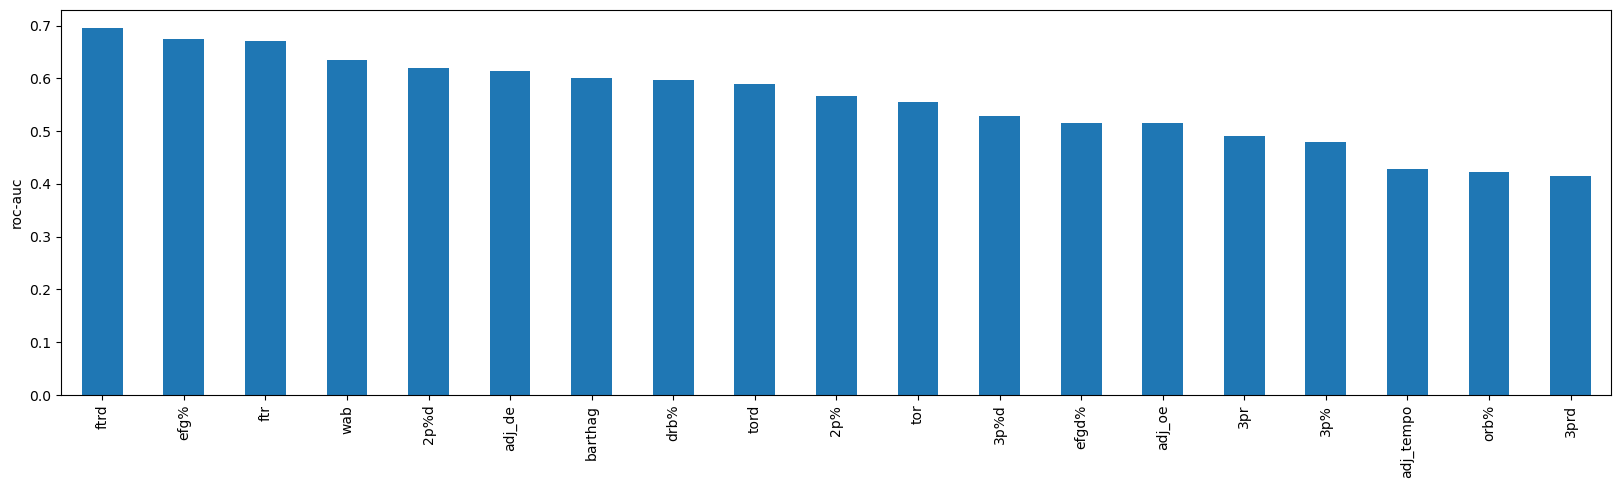

In [36]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [37]:
len(roc_values[roc_values > 0.6])

7

In [38]:
roc_values[roc_values > 0.6]

adj_de    0.6143
barthag   0.6008
efg%      0.6751
ftr       0.6712
ftrd      0.6951
2p%d      0.6195
wab       0.6357
dtype: float64

In [41]:
roc_values[roc_values > 0.55]

adj_de    0.6143
barthag   0.6008
efg%      0.6751
tor       0.5549
tord      0.5898
drb%      0.5963
ftr       0.6712
ftrd      0.6951
2p%       0.5659
2p%d      0.6195
wab       0.6357
dtype: float64

In [48]:
roc_values[roc_values > 0.58]

adj_de    0.6143
barthag   0.6008
efg%      0.6751
tord      0.5898
drb%      0.5963
ftr       0.6712
ftrd      0.6951
2p%d      0.6195
wab       0.6357
dtype: float64

# III. XGBoost

In [55]:
X_train_scaled2 = X_train_scaled[[
'adj_de',
'barthag',
'efg%',
'tord',
'drb%',
'ftr',
'ftrd',
'2p%d',
'wab'
]]

X_test_scaled2 = X_test_scaled[[
'adj_de',
'barthag',
'efg%',
'tord',
'drb%',
'ftr',
'ftrd',
'2p%d',
'wab'
]]

In [56]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.2}


In [57]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [58]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.5070288486627758


In [59]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.90
F1 Score on Test Data: 0.84


<Figure size 1000x600 with 0 Axes>

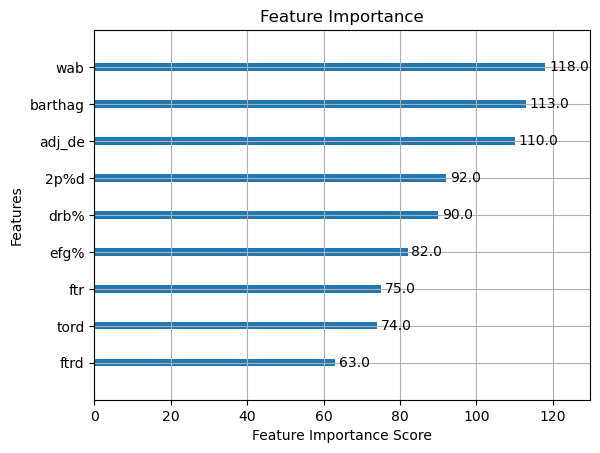

In [60]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()